# Image Preprocessing

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
import os
import cv2

In [ ]:
LABELS_PATH = 'OCTDL_labels.csv'
INPUT_PATH = 'OCTDL'
OUTPUT_PATH = 'augmented_data'

In [ ]:
df = pd.read_csv(LABELS_PATH);
df.head()

,file_name,disease,subcategory,condition,patient_id,eye,sex,year,image_width,image_hight
0,amd_1047099_1,AMD,intermediate,MNV_suspected,1047099,0,0,0,1101,410
1,amd_1047099_2,AMD,intermediate,MNV_suspected,1047099,0,0,0,731,265
2,amd_1047099_3,AMD,intermediate,MNV_suspected,1047099,0,0,0,1100,410
3,amd_1047099_4,AMD,intermediate,MNV_suspected,1047099,0,0,0,882,321
4,amd_1084498_1,AMD,late,MNV,1084498,0,0,0,882,321


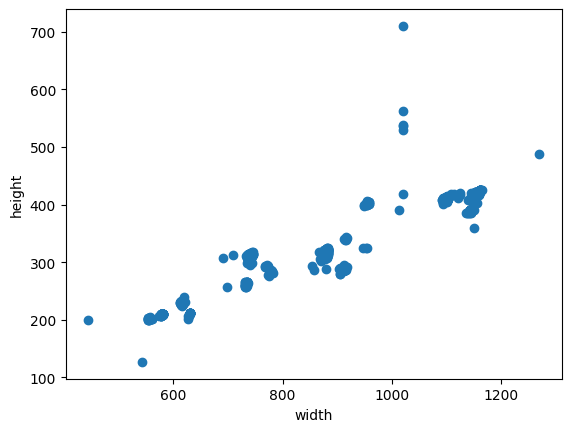

In [18]:
dimensions = pd.DataFrame(df, columns = ['file_name', 'image_width', 'image_hight'])
plt.scatter(dimensions['image_width'], dimensions['image_hight'])
plt.xlabel('width')
plt.ylabel('height')
plt.show()

## Removing outliers
I'm using Z-Score as a method for removing outliers - it measures how many standard deviations a value is from the mean.
I experimented with the threshold until I stopped seeing outliers. 8 images were discarded during this process.

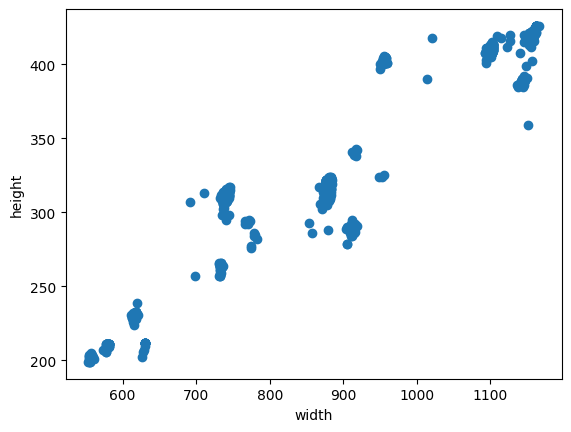

In [50]:
dimensions['z_width'] = zscore(dimensions['image_width'])
dimensions['z_height'] = zscore(dimensions['image_hight'])

z_threshold = 2.5

filtered_dimensions = dimensions[
    (abs(dimensions['z_width']) <= z_threshold) & 
    (abs(dimensions['z_height']) <= z_threshold)
].copy() 

plt.scatter(filtered_dimensions['image_width'], filtered_dimensions['image_hight'])
plt.xlabel('width')
plt.ylabel('height')
plt.show()

## Adjusting dimensions
I'm computing the average aspect ratio for the images to know what proportions to use for downsizing. New images are saved in the augmented_data folder.

In [63]:
filtered_dimensions['aspect_ratio'] = filtered_dimensions['image_width'] / filtered_dimensions['image_hight']
avg_aspect_ratio = filtered_dimensions['aspect_ratio'].mean()
avg_aspect_ratio

2.7420627432904223

In [62]:
height = filtered_dimensions['image_hight'].min()
width = round(height * avg_aspect_ratio)
target_size = (width, height)
target_size

(546, 199)

In [ ]:
def resize_and_save(classname):
    input_dir = INPUT_PATH + '/' + classname
    output_dir = OUTPUT_PATH + '/' + classname

    os.makedirs(output_dir, exist_ok = True)

    for _, row in filtered_dimensions.iterrows():
            file_name = row['file_name'] + '.jpg'
            image_path = os.path.join(input_dir, file_name)

            # Read the image
            img = cv2.imread(image_path)
            if img is None:
                print(f"Error loading image {file_name}")
                continue

            resized_img = cv2.resize(img, target_size, interpolation = cv2.INTER_AREA)

            output_path = os.path.join(output_dir, file_name)
            cv2.imwrite(output_path, resized_img)

In [ ]:
classnames = ['AMD', 'DME', 'ERM', 'NO', 'RAO', 'RVO', 'VID']

for classname in classnames:
    resize_and_save(classname)

## Sample data

/var/folders/26/6pkdhxls61d4fsxkt6x5hbs80000gn/T/ipykernel_11658/4263586447.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  file_names = file_names[:n]


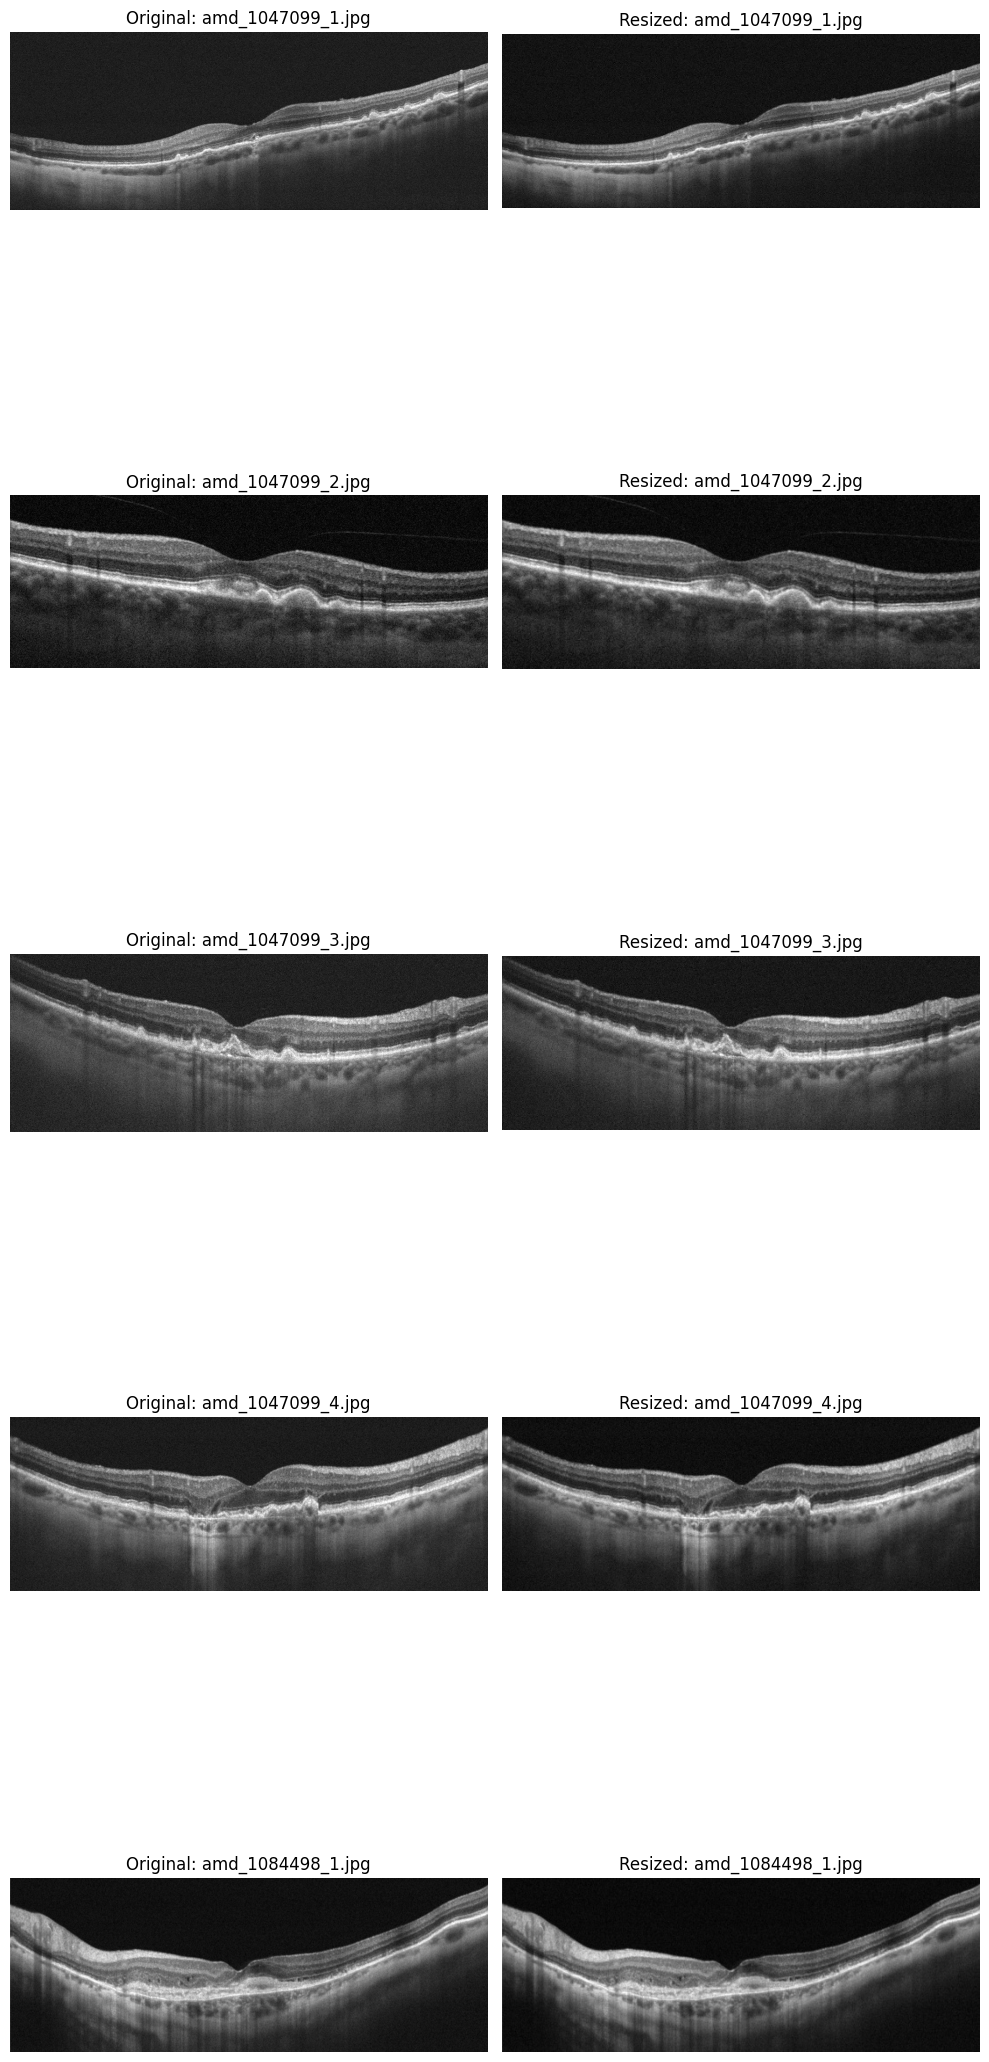

In [ ]:
def display_images(input_dir, output_dir, n=5):
    file_names = filtered_dimensions['file_name'].astype(str) + ".jpg"
    file_names = file_names[:n]
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(10, 5 * n))

    if n == 1: 
        axes = [axes]

    for i, file_name in enumerate(file_names):
        orig_path = os.path.join(input_dir, file_name)
        orig_img = cv2.imread(orig_path, cv2.IMREAD_GRAYSCALE)

        resized_path = os.path.join(output_dir, file_name)
        resized_img = cv2.imread(resized_path, cv2.IMREAD_GRAYSCALE)

        axes[i][0].imshow(orig_img, cmap='gray')
        axes[i][0].set_title(f"Original: {file_name}")
        axes[i][0].axis("off")

        axes[i][1].imshow(resized_img, cmap='gray')
        axes[i][1].set_title(f"Resized: {file_name}")
        axes[i][1].axis("off")

    plt.tight_layout()
    plt.show()

display_images(INPUT_PATH + '/AMD', OUTPUT_PATH + '/AMD', 5)

## Loading the dataset using pytorch
This is an example of loading the dataset in pytorch. To decrease the power needed, the images can be downscaled further, as long as they keep to the proportions where *width = height * 2.74*.

In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np

# hyperparameters - to be adjusted
TEST_TRAIN_SPLIT = 0.3
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(OUTPUT_PATH, transform=transform)

n_test = int(np.floor(TEST_TRAIN_SPLIT * len(dataset)))
n_train = len(dataset) - n_test

train_ds, test_ds = random_split(dataset, [n_train, n_test])

train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)
test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False, num_workers = 4)


# some useful info about the dataset
print(f"Classes: {dataset.classes}")
print(f"Number of training samples: {len(train_ds)}")
print(f"Number of testing samples: {len(test_ds)}")

for i, (x, _) in enumerate(train_dl):
    print(f"Image shape: {x.shape}")
    break

Classes: ['AMD', 'DME', 'ERM', 'NO', 'RAO', 'RVO', 'VID']
Number of training samples: 1440
Number of testing samples: 616
Image shape: torch.Size([32, 1, 199, 546])
